<a href="https://colab.research.google.com/github/samitha278/multilayer-perceptron-char-lm/blob/main/mlp_batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
from google.colab import files

uploaded = files.upload()

Saving names.txt to names.txt


In [3]:
words = open('names.txt','r').read().splitlines()

## Character mapping

In [6]:
stoi = {s:i+1 for i,s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0
itos = {i:s for i,s in stoi.items()}

itos

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

## Dataset split : Train , Dev , Test

In [25]:
def build_dataset(data,n=3):

  x , y = [],[]


  for d in data:

    context = [0]*n

    for ch in d:

      ix = stoi[ch]
      x.append(context)
      y.append(ix)

      ix = context[1:] + [ix]


  x = torch.tensor(x)
  y = torch.tensor(y)

  return x,y


### Train/dev/test - 80/10/10 %

In [26]:
n = len(words)
n1 = int(0.8*n)
n2 = int(0.9*n)


random.shuffle(words)

print(words[:5])

xtr , ytr = build_dataset(words[:n1])
xdev , ydev = build_dataset(words[n1:n2])
xtest , ytest = build_dataset(words[n2:])

['ashari', 'miara', 'lorraine', 'ayham', 'zahriah']


## Parameters Initialization without proper initializataion

In [27]:
char_l = len(stoi.keys())
context_w = 3
vec_size = 10
h_size = 200

In [35]:
g = torch.Generator().manual_seed(21746)

C = torch.randn((char_l,vec_size),              generator=g ,requires_grad=True)
W1 = torch.randn((context_w * vec_size,h_size), generator=g ,requires_grad=True)
b1 = torch.randn(h_size,                        generator=g ,requires_grad=True)
W2 = torch.randn((h_size,char_l),               generator=g ,requires_grad=True)
b2 = torch.randn(char_l,                        generator=g ,requires_grad=True)

params = [C,W1,b1,W2,b2]

## Full pass

In [36]:
max_iter = 10000
losses = []
lr = 0.01

In [37]:
for i in range(max_iter):


  #minibatch
  ix = torch.randint(0,xtr.shape[0],(32,))


  #forward pass

  #embedding
  emb = C[xtr[ix]]
  emb_cor =  emb.view(-1,vec_size*context_w)

  #hidden layer
  h_preact = emb_cor @ W1 + b1
  h = torch.tanh(h_preact)

  #output layer
  logits = h @ W2 +b2

  loss = F.cross_entropy(logits,ytr[ix])


  #backward pass
  for p in params:
    p.grad = None

  loss.backward()


  #update
  for p in params:
    p.data -= lr * p.grad

  if i%1000==0:
    print(f'{i}/{max_iter}  : {loss}')

  losses.append(loss.item())



0/10000  : 30.188505172729492
1000/10000  : 3.293705701828003
2000/10000  : 2.706843852996826
3000/10000  : 2.8702828884124756
4000/10000  : 2.8582096099853516
5000/10000  : 2.6461563110351562
6000/10000  : 2.670987129211426
7000/10000  : 2.8419766426086426
8000/10000  : 2.7493748664855957
9000/10000  : 2.6659324169158936


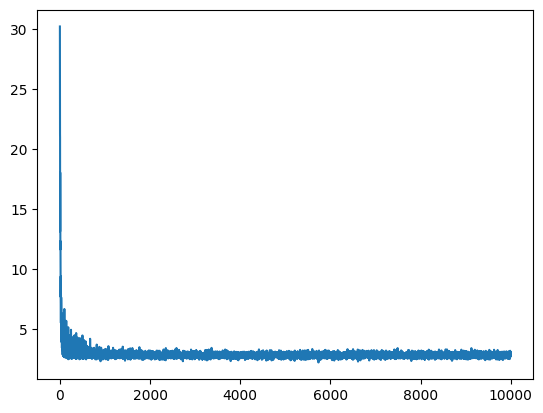

In [39]:
plt.plot(losses)
plt.show()

### Why does the loss curve look like a hockey stick?  

- At the beginning of training, if the model is **not properly initialized**, the initial loss can be **very high**.  
- As training progresses, the optimizer quickly reduces this large error, causing a **sharp drop** in the loss.  
- After this rapid decrease, the loss decreases more slowly and flattens out, forming the **"hockey stick" shape**.  


##